In [1]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

import warnings
warnings.filterwarnings('ignore')

In [2]:
DATASET_PATH = '../content/car data.csv'

### 1. Первичный анализ данных

In [3]:
df = pd.read_csv(DATASET_PATH, sep=',')
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [5]:
df.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


Датасет имеет 301 наблюдение, пропусков нет. Всего 9 признаков, 5 числовых, 4 категориальных. Целевой признак - `Selling_Price`

### 2. Визуальный анализ данных

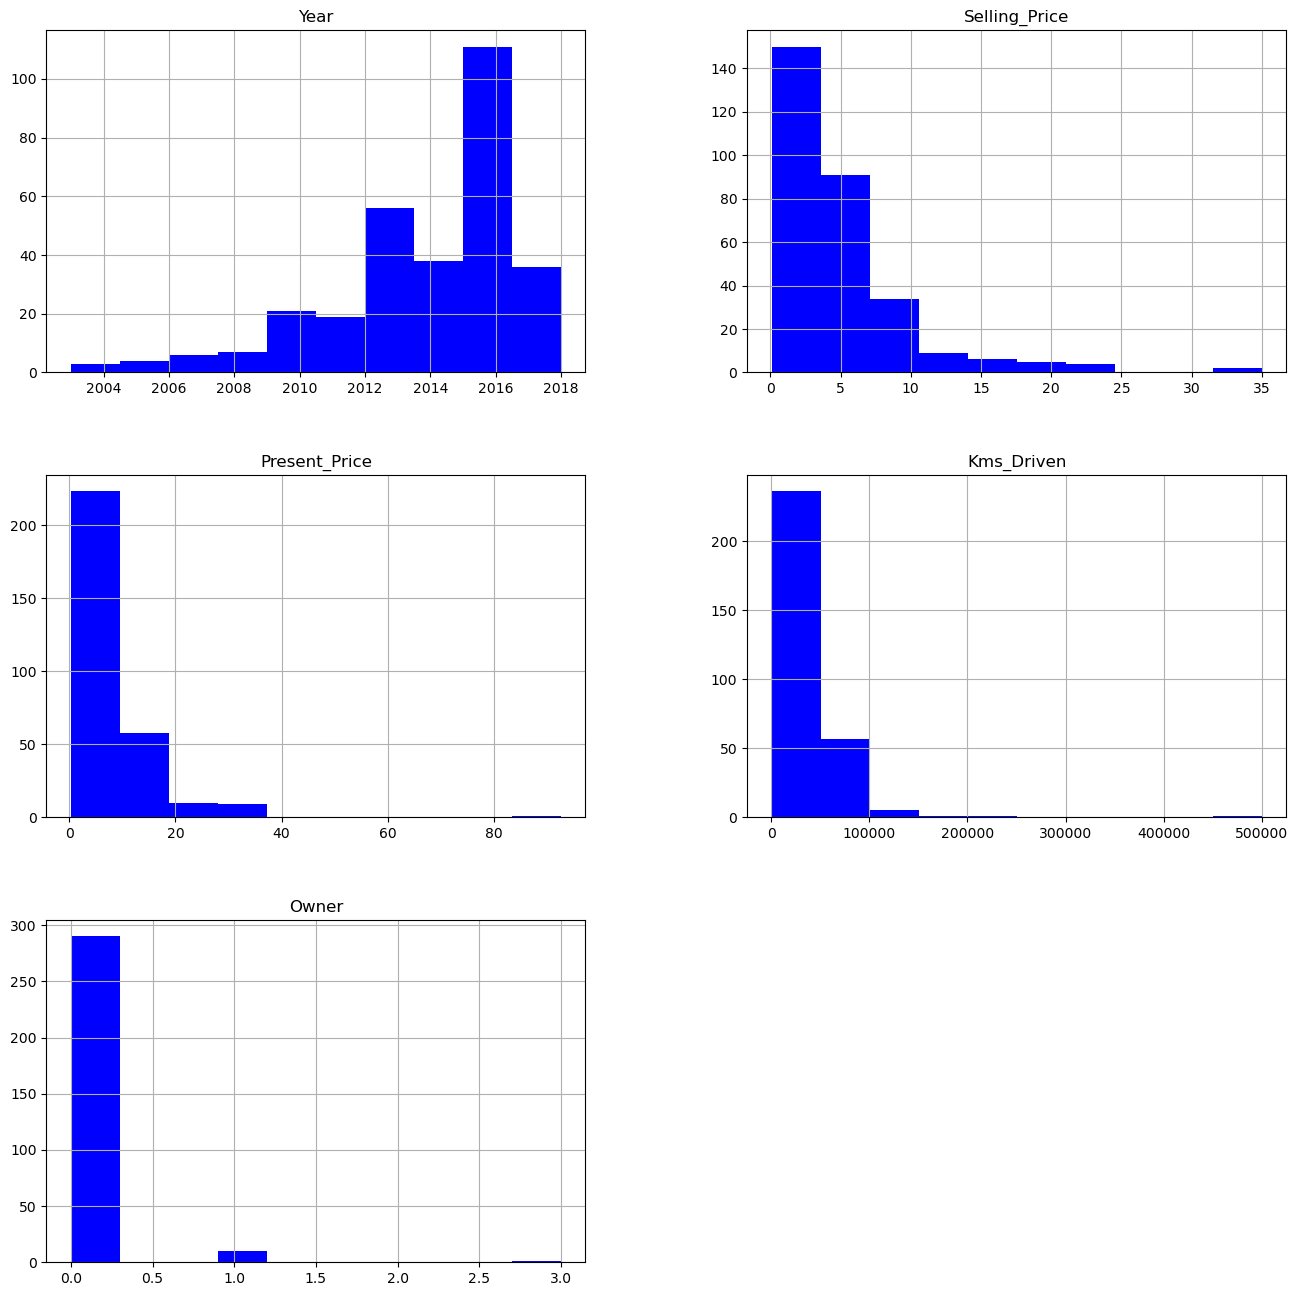

In [6]:
df.hist(figsize=(16, 16), color='b');

Признаки `Selling_Price`, `Present_Price` и `Kms_Driven` имеют выбросы сверху:

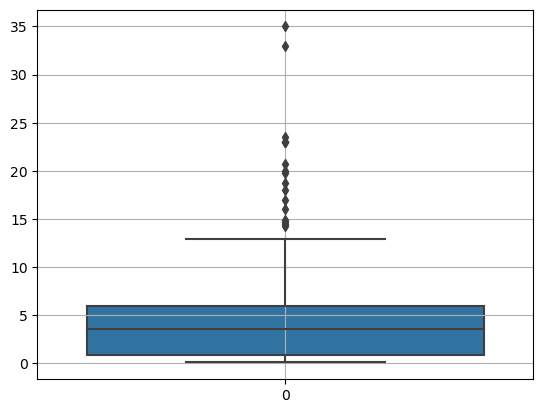

In [7]:
sns.boxplot(df['Selling_Price'], whis=1.5)
plt.grid(True);

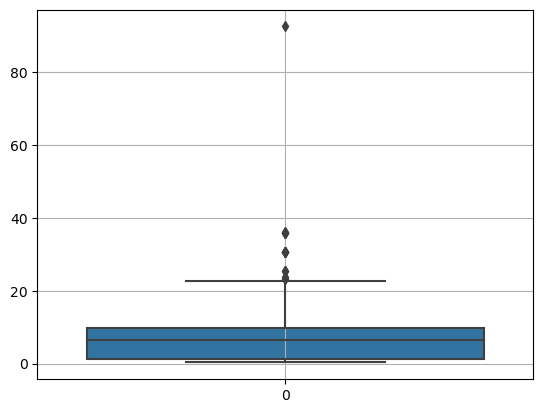

In [8]:
sns.boxplot(df['Present_Price'], whis=1.5)
plt.grid(True);

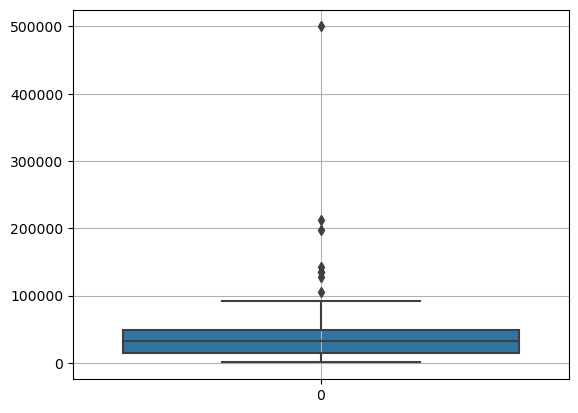

In [9]:
sns.boxplot(df['Kms_Driven'], whis=1.5)
plt.grid(True);

Посмотрим на матрицу корреляций:

In [10]:
corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

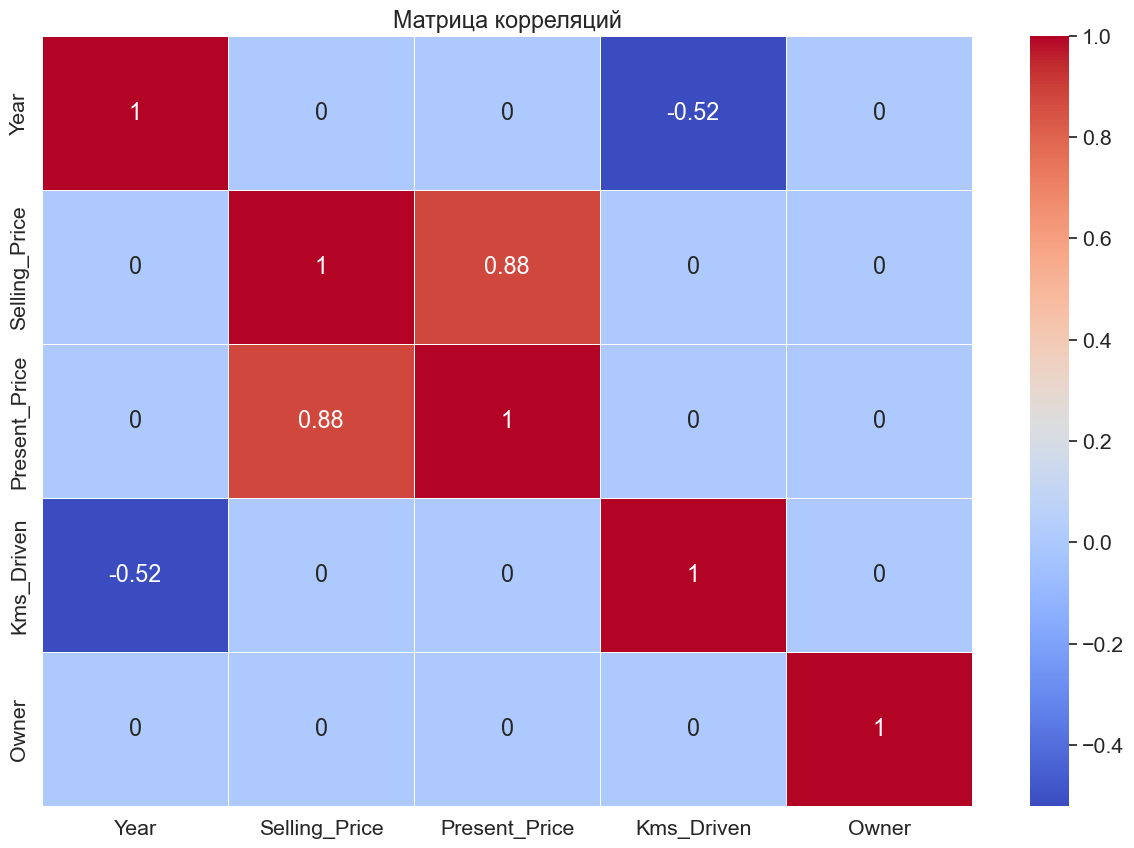

In [11]:
plt.figure(figsize=(15, 10))
sns.set(font_scale=1.4)
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.title('Матрица корреляций');

Целевой признак `Selling_Price` имеет сильную линейную зависимость (корреляцию) от признака `Present_Price`:

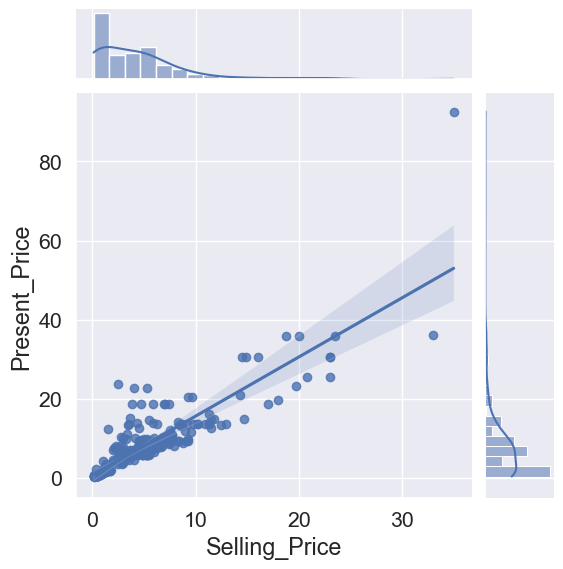

In [12]:
sns.jointplot(df, x='Selling_Price', y='Present_Price', kind='reg');

### 3. Разбиение данных на обучение и тест

In [13]:
# отделяем таргет от остальных фичей
X = df.drop(columns='Selling_Price')
y = df['Selling_Price']

# разбиваем
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X
                                                                        , y
                                                                        , test_size=0.3
                                                                        , shuffle=True
                                                                        , random_state=42)
X_train_orig.head()

,Car_Name,Year,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
185,Suzuki Access 125,2008,0.58,1900,Petrol,Individual,Automatic,0
72,corolla altis,2013,18.61,56001,Petrol,Dealer,Manual,0
15,ertiga,2016,10.79,43000,Diesel,Dealer,Manual,0
10,alto 800,2017,3.60,2135,Petrol,Dealer,Manual,0
196,Activa 3g,2008,0.52,500000,Petrol,Individual,Automatic,0


### 4. Удаление категориальных признаков

In [14]:
dtypes = ['float64', 'int64']

X_train_orig = X_train_orig.select_dtypes(dtypes)
X_test_orig = X_test_orig.select_dtypes(dtypes)

X_train_orig.head(), X_train_orig.head()

(     Year  Present_Price  Kms_Driven  Owner
 185  2008           0.58        1900      0
 72   2013          18.61       56001      0
 15   2016          10.79       43000      0
 10   2017           3.60        2135      0
 196  2008           0.52      500000      0,
      Year  Present_Price  Kms_Driven  Owner
 185  2008           0.58        1900      0
 72   2013          18.61       56001      0
 15   2016          10.79       43000      0
 10   2017           3.60        2135      0
 196  2008           0.52      500000      0)

### 5. Предобработка данных с помощью класса и пайплайна

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin


class DataPipeline(BaseEstimator, TransformerMixin):
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        # максимальные значения
        self.selling_price_max = None
        self.present_price_max = None
        self.kms_driven_max = None
        # self.y_max = None

        # средние значения
        self.selling_price_mean = None
        self.present_price_mean = None
        self.kms_driven_mean = None
        # self.y_mean = None

    def fit(self, df, y=None):
        """Сохранение статистик"""
        
        if 'Selling_Price' in df.columns:
            self.IQR_SP = df['Selling_Price'].quantile(.75) - df['Selling_Price'].quantile(.25)
            self.selling_price_max = df['Selling_Price'].quantile(.75) + 1.5 * self.IQR_SP
            self.selling_price_mean = df['Selling_Price'].mean()
        if 'Present_Price' in df.columns:
            self.IQR_PP = df['Present_Price'].quantile(.75) - df['Present_Price'].quantile(.25)
            self.present_price_max = df['Present_Price'].quantile(.75) + 1.5 * self.IQR_PP
            self.present_price_mean = df['Present_Price'].mean()
        if 'Kms_Driven' in df.columns:
            self.IQR_KD = df['Kms_Driven'].quantile(.75) - df['Kms_Driven'].quantile(.25)
            self.kms_driven_max = df['Kms_Driven'].quantile(.75) + 1.5 * self.IQR_KD
            self.kms_driven_mean = df['Kms_Driven'].mean()
        # if y is not None:
        #     self.IQR_y = y.quantile(0.75) - y.quantile(0.25)
        #     self.y_max = y.quantile(.75) + 1.5 * self.IQR_y
        #     self.y_mean = y.mean()
        
        return self

    def transform(self, df, y=None):
        """Трансформация данных"""

        if 'Selling_Price' in df.columns:
            df.loc[df['Selling_Price'] > self.selling_price_max, 'Selling_Price'] = self.selling_price_mean
        if 'Present_Price' in df.columns:
            df.loc[df['Present_Price'] > self.present_price_max, 'Present_Price'] = self.present_price_mean
        if 'Kms_Driven' in df.columns:
            df.loc[df['Kms_Driven'] > self.kms_driven_max, 'Kms_Driven'] = self.kms_driven_mean
        # if y is not None:
        #     y[y > self.y_max] = self.y_mean

        return df#, y

In [16]:
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    DataPipeline(),
    PolynomialFeatures(interaction_only=True,),
    StandardScaler(),
)

In [17]:
pipe.fit(X_train_orig,)

Pipeline(steps=[('datapipeline', DataPipeline()),
                ('polynomialfeatures',
                 PolynomialFeatures(interaction_only=True)),
                ('standardscaler', StandardScaler())])

In [18]:
# преобразовываем признаки
X_train = pipe.transform(X_train_orig,)
X_test = pipe.transform(X_test_orig,)

In [19]:
# преобразовываем целевой признак (не получилось сделать в классе)
def y_transform(y):
    IQR_y = y.quantile(0.75) - y.quantile(0.25)
    y_max = y.quantile(0.75) + 1.5 * IQR_y
    y[y > y_max] = y.mean()

    return y

y_train = y_transform(y_train_orig)
y_test = y_transform(y_test_orig)

### 6. Обучение модели регрессии с целевым признаком `Selling_Price`

In [20]:
lr_model_train = LinearRegression()
lr_model_train.fit(X_train, y_train)

y_train_preds = lr_model_train.predict(X_train)

In [21]:
lr_model_test = LinearRegression()
lr_model_test.fit(X_test, y_test)

y_test_preds = lr_model_test.predict(X_test)

### 7. Оценка метрик качества

In [22]:
def evaluate_preds(true_values, pred_values, title=''):
    """Оценка качества модели и график preds vs true"""

    # считаем метрики
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    # строим графики
    plt.figure(figsize=(8, 8))

    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 14], [0, 14], linestyle='--', color='black')  # диагональ, где true_values = pred_values

    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    plt.title(title);



R2:	0.804
RMSE:	1.324
MSE:	1.754


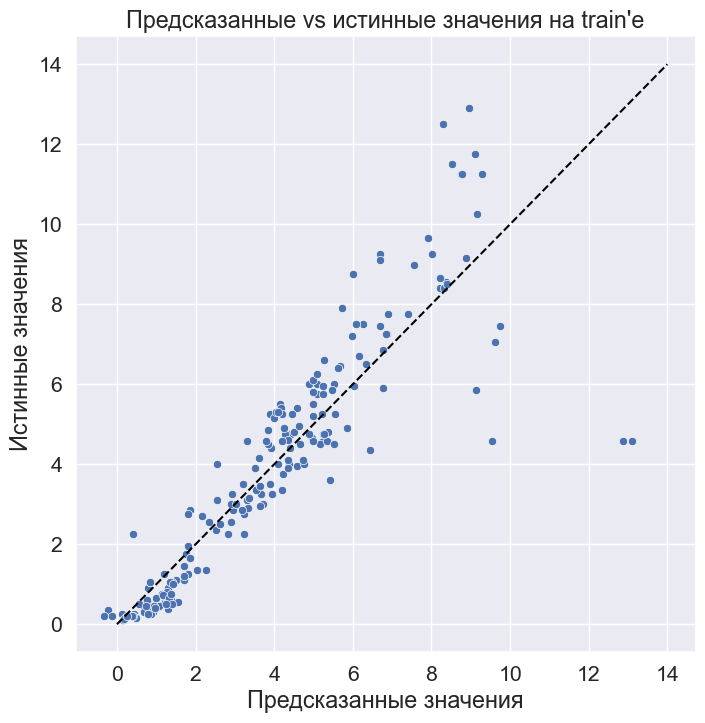

In [23]:
evaluate_preds(y_train, y_train_preds, 'Предсказанные vs истинные значения на train\'е')

R2:	0.804
RMSE:	1.289
MSE:	1.662


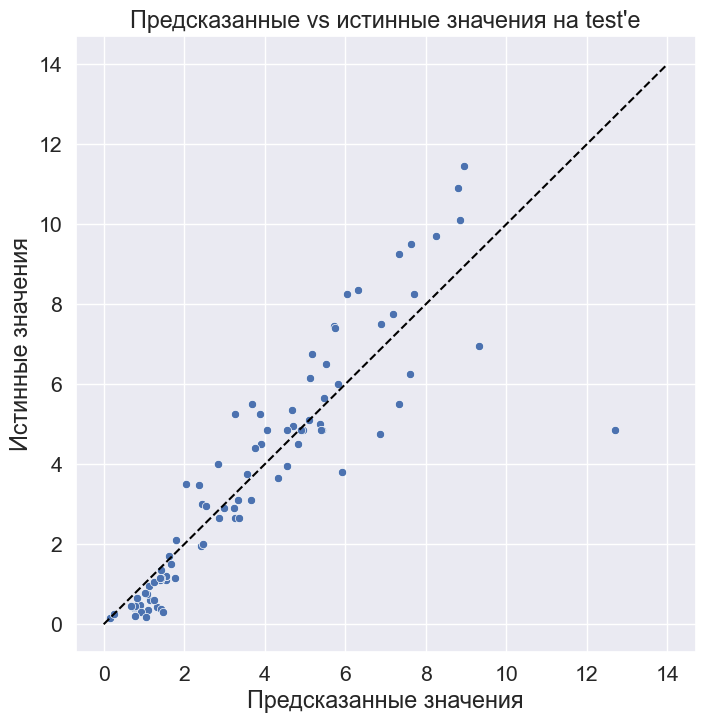

In [24]:
evaluate_preds(y_test, y_test_preds, 'Предсказанные vs истинные значения на test\'е')

### 8. Выводы по проделанной работе

Модель обучилась достаточно хорошо ($R^2$-метрика равна 0.804 для train'а и для test'а, `MSE` больше на train'e) несмотря на то, что целевой признак `Selling_price` имеет сильную линейную зависимость только от одного признака `Present_price`. Это стало возможным благодаря предобработке данных, их масштабированию и добавлению нелинйности (в виде перемножения признаков друг на друга).